# Team 4 - Phase 1

## Overview of Project

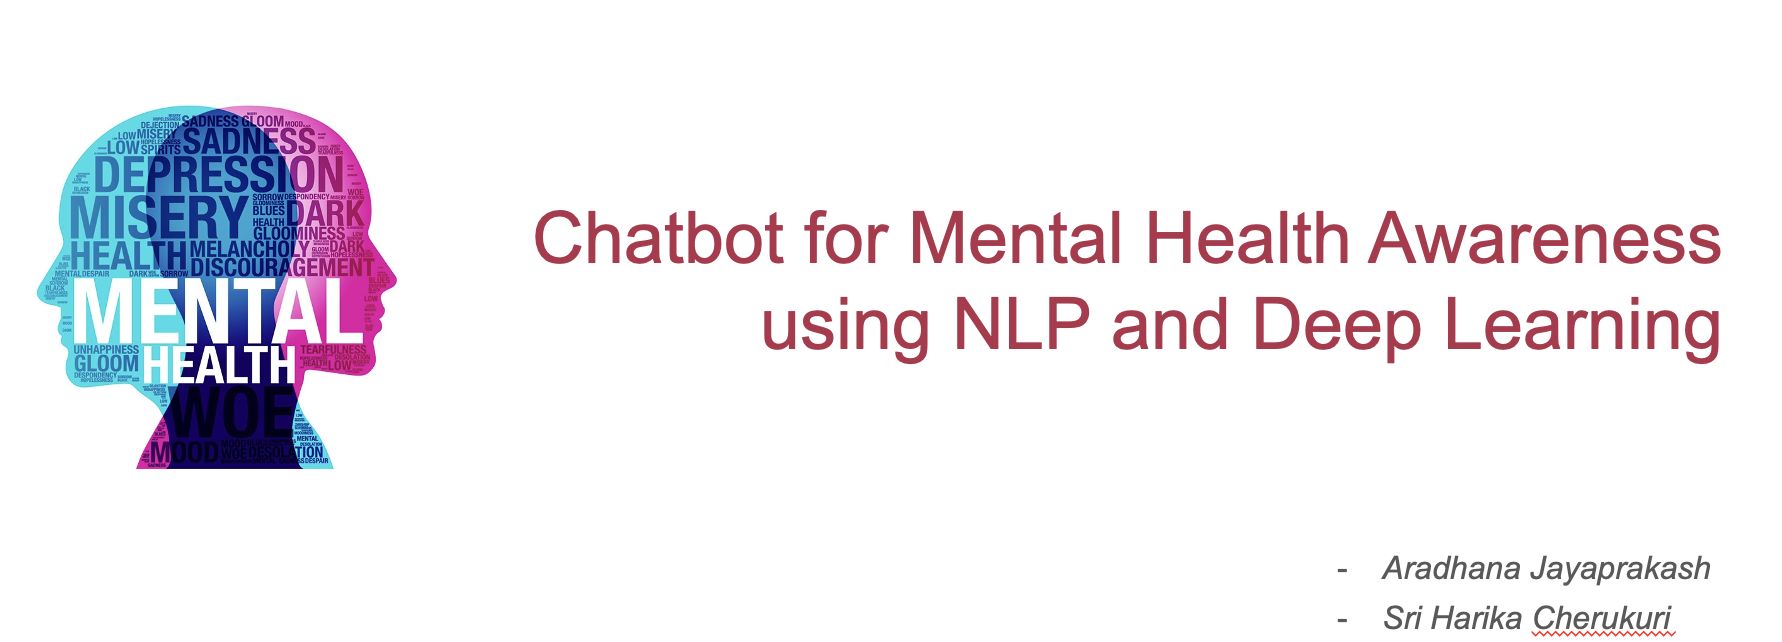

Purpose - The goal of this project is to develop a chatbot using Natural Language Processing and Deep Learning to promote mental Health Awareness. Stigma and lack of access to mental health professionals can make it difficult for individuals to get the help they need. Chatbots have the potential to bridge this gap by providing a convenient, accessible, and confidential means for individuals to learn about mental health and get support.

Solution - We aim to have the chatbot understand and respond to user input in a natural and conversational manner providing information and resources on various health topics.

#### Overall Organization of the program - 

For our first codewalk, we experimented with retreival based models for our chatbots using a collection of mental health data - conversations between 
therapists and clients to help our model better understand and respond to messages appropriately. The project layout is as follows :

1.   Data Preprocessing

2.   Model Building (Sequence to Sequence Neural Networks)

3.   Predicting Responses

In [2]:
import json
import random
import re
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

In [3]:
with open('intents.json', 'r') as f:
    intents = json.load(f)

### Data 
The data used to train our model is in the form of json intents - which contain tag - which represents the type of text, pattern - which represents the texts belonging to that particular type and responses - containing appropriate responses for the tags and patterns.


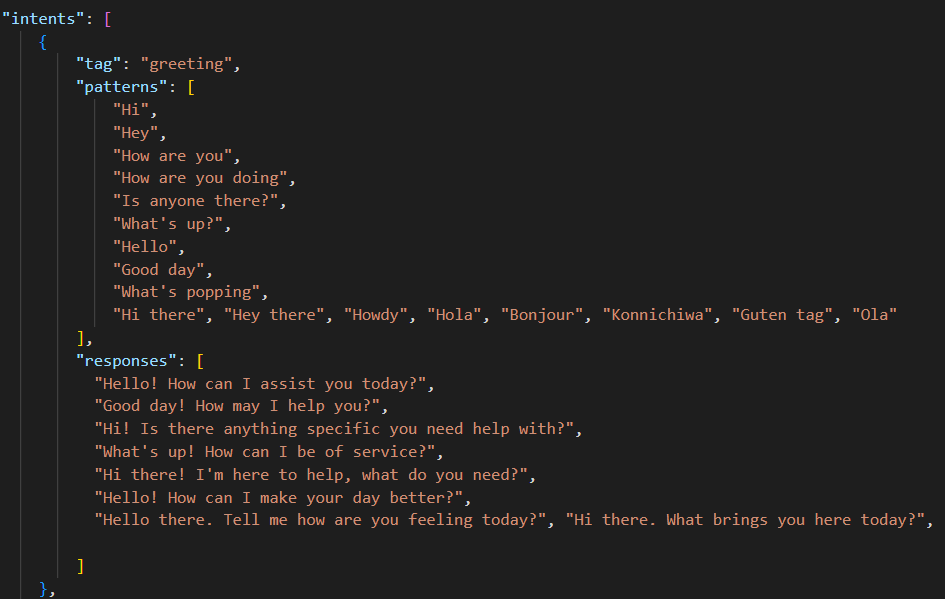

### Data Pre-processing

In [4]:
def data_clean(data):
    """
    Build a mental health chatbot using the given data in json format.
    The data should include "tag", "patterns", and "responses" as keys.
    
    :param data: (dict) mental health data in json format
    :return: words, tuple of word and tag and tags
    """
    tags = []
    words=[]
    doc = []
    
    for intent in data['intents']:
        for question in intent['patterns']:
            ques = re.sub(r'[^\w\s]', '',question.lower())
            ques = word_tokenize(ques)
            ques = [WordNetLemmatizer().lemmatize(w) for w in ques]
            words.extend(ques)
            doc.append((ques,intent['tag']))
            
            #adding unique items to the tag list
            if intent['tag'] not in tags:
                tags.append(intent['tag'])
    
    return sorted(list(set(words))), doc, tags


### Bag of Words

In [5]:
def bow(sentence, words, show_details=True):
    """
    This function creates a bag of words representation.
    The bag of words representation is a matrix of N words, with the vocabulary matrix.
    If a word from the sentence appears in the vocabulary, it is assigned a value of 1 in the bag of words representation.
    
    Parameters:
        sentence (str): The input sentence to be tokenized.
        words (list): List of words in the vocabulary.
        show_details (bool, optional): Flag to print details of the words found in the bag of words representation. Default is True.
    
    Returns:
        numpy.ndarray: A bag of words representation of the input sentence.
    """
    # tokenize the pattern
    sen = re.sub(r'[^\w\s]', '',sentence.lower())
    sen = word_tokenize(sen)
    sen = [WordNetLemmatizer().lemmatize(w) for w in sen]
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words) 
    for s in sen:
        for i,w in enumerate(words):
            if w == s: 
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))


### Training Data

In [6]:
def create_training_data(intents):
    """
    Create training data from the intents data.
    
    Parameters:
    intents (dict): Dictionary of intents, where each key is a tag, and the value is a list of patterns for that intent.
    
    Returns:
    training (list): List of training data, where each element is a tuple of the bag of words representation of the input and the one-hot encoded label.
    train_x (list): List of inputs in the training data.
    train_y (list): List of labels in the training data.
    """
    training = []
    responses = [0] * len(data_clean(intents)[2])
    
    for d in data_clean(intents)[1]:
        # Bag of words
        bag = []
        input_words = d[0]
        input_words = [WordNetLemmatizer().lemmatize(w.lower()) for w in input_words]
        
        for w in data_clean(intents)[0]:
            bag.append(1) if w in input_words else bag.append(0)
        responses_row = list(responses)
        responses_row[data_clean(intents)[2].index(d[1])] = 1
        training.append([bag, responses_row])
    
    random.shuffle(training)
    training = np.array(training)
    train_x = list(training[:, 0])
    train_y = list(training[:, 1])    
    
    return train_x, train_y

### Model Building

In [7]:
def chatbot_model(train_x, train_y):
    """
    Create a neural network model using the Sequential class from the Keras library. 
    The model has 3 layers: the first layer has 128 neurons, the second layer has 64 neurons, 
    and the third layer has the number of neurons equal to the number of intents to predict the output intent with softmax.

    Parameters:
    train_x (list): List of training data inputs
    train_y (list): List of training data labels

    Returns:
    model (Sequential): Compiled and fit Keras model
    """
    model = Sequential()
    model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(train_y[0]), activation='softmax'))
    sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
    return model


### Predicting the Tag

In [8]:
def predict_tag(sentence, words, model):
    """
    Given a sentence and the trained model, the function returns the list of intents with probability.
    
    Parameters:
    sentence (str): The input sentence.
    model (Sequential): The trained model.
    
    Returns:
    list: A list of dictionaries containing intent and its corresponding probability for each intent.
    
    """
    # preprocess the input sentence and convert into numerical representation
    p = bow(sentence, words,show_details=False)
    # probability score is returned from the model
    res = model.predict(np.array([p]))[0]
    # filtering scores based on some threshold 
    threshold = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>threshold]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": data_clean(intents)[2][r[0]], "probability": str(r[1])})
    return return_list

### Getting the response

In [9]:
def getResponse(tags, json_input):
    """
    This function takes in the list of intents and intents_json as inputs and returns the corresponding response.
    
    Parameters:
    ints (list): List of dictionaries containing intent and its probability.
    intents_json (dictionary): A dictionary containing the intents and corresponding responses.
    
    Returns:
    str: The corresponding response for the given intent.
    """
    tag = tags[0]['intent']
    list_of_intents = json_input['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

### Generating chatbot response

In [10]:
def chatbot_response(text,words,model):
    """
    This function takes in the text as input and returns the chatbot's response.
    
    Parameters:
    text (str): The input text given to the chatbot.
    
    Returns:
    str: The response from the chatbot for the given input text.
    """
    predict_tags = predict_tag(text, words, model)
    res = getResponse(predict_tags, intents)
    return res

In [11]:
train_x, train_y = create_training_data(intents)
model = chatbot_model(train_x, train_y)
words = data_clean(intents)[0]

Epoch 1/200


/var/folders/3c/q875p1_979j40ck65t4g0y640000gn/T/ipykernel_12883/2905785953.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)
2023-02-15 11:22:42.181247: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15/15 [==============================] - 0s 599us/step - loss: 2.3179 - accuracy: 0.0423
Epoch 2/200
15/15 [==============================] - 0s 453us/step - loss: 2.1387 - accuracy: 0.2113
Epoch 3/200
15/15 [==============================] - 0s 502us/step - loss: 2.0220 - accuracy: 0.2817
Epoch 4/200
15/15 [==============================] - 0s 552us/step - loss: 2.0006 - accuracy: 0.2817
Epoch 5/200
15/15 [==============================] - 0s 482us/step - loss: 1.8803 - accuracy: 0.5352
Epoch 6/200
15/15 [==============================] - 0s 553us/step - loss: 1.8175 - accuracy: 0.3944
Epoch 7/200
15/15 [==============================] - 0s 476us/step - loss: 1.6507 - accuracy: 0.4930
Epoch 8/200
15/15 [==============================] - 0s 522us/step - loss: 1.5519 - accuracy: 0.4789
Epoch 9/200
15/15 [==============================] - 0s 463us/step - loss: 1.2726 - accuracy: 0.6338
Epoch 10/200
15/15 [==============================] - 0s 457us/step - loss: 1.2935 - accuracy: 0.6338
E

15/15 [==============================] - 0s 442us/step - loss: 0.0885 - accuracy: 0.9577
Epoch 82/200
15/15 [==============================] - 0s 475us/step - loss: 0.0837 - accuracy: 0.9577
Epoch 83/200
15/15 [==============================] - 0s 433us/step - loss: 0.1238 - accuracy: 0.9437
Epoch 84/200
15/15 [==============================] - 0s 473us/step - loss: 0.0742 - accuracy: 0.9718
Epoch 85/200
15/15 [==============================] - 0s 468us/step - loss: 0.0680 - accuracy: 0.9859
Epoch 86/200
15/15 [==============================] - 0s 440us/step - loss: 0.1401 - accuracy: 0.9577
Epoch 87/200
15/15 [==============================] - 0s 434us/step - loss: 0.1019 - accuracy: 0.9577
Epoch 88/200
15/15 [==============================] - 0s 467us/step - loss: 0.1916 - accuracy: 0.9437
Epoch 89/200
15/15 [==============================] - 0s 429us/step - loss: 0.0831 - accuracy: 0.9577
Epoch 90/200
15/15 [==============================] - 0s 472us/step - loss: 0.0907 - accuracy: 

15/15 [==============================] - 0s 434us/step - loss: 0.1070 - accuracy: 0.9437
Epoch 161/200
15/15 [==============================] - 0s 487us/step - loss: 0.0627 - accuracy: 0.9718
Epoch 162/200
15/15 [==============================] - 0s 447us/step - loss: 0.1262 - accuracy: 0.9296
Epoch 163/200
15/15 [==============================] - 0s 494us/step - loss: 0.0857 - accuracy: 0.9577
Epoch 164/200
15/15 [==============================] - 0s 443us/step - loss: 0.0695 - accuracy: 0.9577
Epoch 165/200
15/15 [==============================] - 0s 472us/step - loss: 0.1361 - accuracy: 0.9437
Epoch 166/200
15/15 [==============================] - 0s 445us/step - loss: 0.0717 - accuracy: 0.9577
Epoch 167/200
15/15 [==============================] - 0s 473us/step - loss: 0.0480 - accuracy: 0.9859
Epoch 168/200
15/15 [==============================] - 0s 424us/step - loss: 0.0733 - accuracy: 0.9718
Epoch 169/200
15/15 [==============================] - 0s 418us/step - loss: 0.0954 - a

In [20]:
while True:
    new_input = input("You: ")
    if new_input == 'exit':
        break
    response = chatbot_response(new_input,words,model)
    print("Buddy:", response)

You: Hello
1/1 [==============================] - 0s 13ms/step
Buddy: Hi there! I'm here to help, what do you need?
You: May I know who you are?
1/1 [==============================] - 0s 13ms/step
Buddy: Absolutely! I am Buddy, your virtual friend and support system. I was created to help with various life challenges, and to offer a non-judgmental ear to listen and support you in any way I can.
You: I'm feeling really depressed
1/1 [==============================] - 0s 12ms/step
Buddy: I'm here to listen. If you're feeling depressed, it's important to reach out for help. Depression is a common and serious medical illness that negatively affects how you feel, the way you think and how you act. It is a mood disorder that causes a persistent feeling of sadness and loss of interest. It can be treated with therapy, medication, or a combination of both. It's important to remember that depression is not a weakness and it's nothing to be ashamed of. If you're struggling, reaching out to friend